In [1]:
import ollama
from ollama import chat

from huggingface_hub import snapshot_download

from docling.datamodel.pipeline_options import PdfPipelineOptions, RapidOcrOptions, PictureDescriptionApiOptions
from docling.backend.pypdfium2_backend import PyPdfiumDocumentBackend
from docling.datamodel.base_models import InputFormat
from docling.document_converter import DocumentConverter, PdfFormatOption
from docling.chunking import HybridChunker
from docling_core.types.doc import PictureItem, TableItem, TextItem
from docling_core.types.doc.labels import DocItemLabel

from pydantic.v1 import BaseModel

from transformers import AutoTokenizer
from sentence_transformers import CrossEncoder

from BM25 import load_bm25, create_bm25, bm25_search
from util.docling_util import *
from util.qdrant_util import qdrant_DBConnector, DataObject
from util.text_splitter import RecursiveTextSplitter, DataFrameFormatter
from util.ollama_util import *

import os
import json
from pathlib import Path

from openai import OpenAI
from dotenv import load_dotenv, find_dotenv

/Users/yoyo/opt/anaconda3/envs/cathay_llm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# document local path or URL
doc = "./test_doc/國泰人壽祿美富利率變動型美元終身壽險（定期給付型）.pdf" # simple text with a image and table
doc1 = "./test_doc/吉美利101利率變動型美元終身壽險(定期給付型)DM.pdf" # complex text with simple aesthetic table
doc2 = "./test_doc/美利雙寶利率變動型美元終身保險 (定期給付型)DM.pdf" # complex text with complex aesthetic table
doc3 = "./test_doc/國泰金控出勤管理須知(修正後).pdf" # simple text with a simple table
doc4 = "./test_doc/國泰金控員工國內出差要點.pdf" # simple text with a simple table
doc5 = "./test_doc/國泰金控員工國外出差要點.pdf" # simple text with complex table
doc6 = "./test_doc/國泰金融控股股份有限公司資訊安全管理辦法.pdf" # simple text
doc7 = "./test_doc/國泰金融控股股份有限公司_後台維護系統管理作業要點_F.pdf" # flow map with blank table
doc8 = "./test_doc/國泰金融控股股份有限公司金融科技創新業務管理辦法_20240125.pdf" # flow map
doc9 = "./test_doc/國泰金控暨子公司「對話機器人 - 阿發」視覺形象管理辦法.pdf" # complex figure design doc
doc10 = "./test_doc/國泰醫院113年工作計畫.pdf" # cross page table and HAS index, scanned document OCR needed
doc11 = "./test_doc/國泰醫院113年經費預算.pdf" # large number table, scanned document OCR needed
doc12 = "./test_doc/國泰醫院112年工作報告.pdf" # table with check board inside, scanned document OCR needed
doc13 = "./test_doc/112年國泰醫療財團法人財務報告.pdf" # loose structured table, scanned document OCR needed
doc14 = "./test_doc/111年4-6月愛心捐款及捐贈物資徵信名冊.pdf" #compacted table
doc15 = "./test_doc/畢業學分審核表.pdf" # vertical table

# ollama embedding model
embed_model = "bge-m3:latest"

# reranker 
#rerank_model = CrossEncoder('BAAI/bge-reranker-large', max_length=512)
#rerank_model = CrossEncoder('BAAI/bge-reranker-v2-m3', max_length=8192)
rerank_model = CrossEncoder('BAAI/bge-reranker-v2-m3', max_length=1024)

# ollama llm
#llm = "deepseek-r1:7b"
#llm = "deepseek-r1:14b"
#llm = "deepseek-r1:32b"
#llm = "deepseek-r1:14b-max-context"
llm = "deepseek-r1:14b-quarter-context"
#llm = "deepseek-r1:14b-eighth-context"

# PyPdfium without EasyOCR
# --------------------
"""pipeline_options = PdfPipelineOptions()
pipeline_options.do_ocr = False
pipeline_options.do_table_structure = True
pipeline_options.table_structure_options.do_cell_matching = False
#pipeline_options.table_structure_options.do_cell_matching = True

#pipeline_options.table_structure_options.mode = 'accurate'

pipeline_options.images_scale = 2
pipeline_options.generate_page_images = True
pipeline_options.generate_picture_images = True

pypdfium_converter = DocumentConverter(
    format_options={
        InputFormat.PDF: PdfFormatOption(
        pipeline_options=pipeline_options, backend=PyPdfiumDocumentBackend
        )
    }
)"""

# PyPdfium with RapidOCR
# ----------------------
# Download RappidOCR models from HuggingFace
print("Downloading RapidOCR models")
download_path = snapshot_download(repo_id="SWHL/RapidOCR")

det_model_path = os.path.join(
    download_path, "PP-OCRv4", "ch_PP-OCRv4_det_infer.onnx"
)
rec_model_path = os.path.join(
    download_path, "PP-OCRv4", "ch_PP-OCRv4_rec_infer.onnx"
)
cls_model_path = os.path.join(
    download_path, "PP-OCRv3", "ch_ppocr_mobile_v2.0_cls_train.onnx"
)
ocr_options = RapidOcrOptions(
    det_model_path=det_model_path,
    rec_model_path=rec_model_path,
    cls_model_path=cls_model_path,
    #force_full_page_ocr=True
)

pipeline_options = PdfPipelineOptions()
pipeline_options.do_ocr = True
#pipeline_options.do_ocr = False
pipeline_options.do_table_structure = True
pipeline_options.table_structure_options.do_cell_matching = True
#pipeline_options.table_structure_options.do_cell_matching = False
pipeline_options.table_structure_options.mode = 'accurate'

pipeline_options.images_scale = 2.0
pipeline_options.generate_page_images = True
pipeline_options.generate_picture_images = True

pipeline_options.ocr_options = ocr_options

# VLM with OpenAI
# ----------------------
"""def openai_vlm_options():
    load_dotenv()
    api_key = os.environ.get("OPENAI_API_KEY")
    if not api_key:
        raise ValueError("OPENAI_API_KEY not found in environment variables")

    options = PictureDescriptionApiOptions(
        url="https://api.openai.com/v1/chat/completions",
        headers={
            "Authorization": f"Bearer {api_key}",
            "Content-Type": "application/json",
        },
        params = dict(
            model="gpt-4o",
            max_tokens=1024,
            temperature=0.7
        ),
        prompt = (
            #f"請仔細閱讀這張來自文檔「{filename}」的圖片內容。綜合檔名和你取得的內容資訊，完成以下任務：\n"
            f"請仔細閱讀這張來自文檔的圖片內容。綜合你取得的內容資訊，完成以下任務：\n"
            "1. 用簡潔清楚的方式描述或摘要圖片的主要內容。\n"
            "2. 擷取圖片中出現的重要概念、重點事項或關鍵字以利後續搜尋。\n"
            "3. 如果是結構化資訊（如表格、流程圖），請嘗試條列或描述其架構，不要私自精簡原來的文字表達。\n"
            "4. 僅回傳內容，不要加入與提示無關的說明。\n"
            "請以繁體中文回答。\n"
            "請注意，回答內容請控制在 1000 個字以內，不要超過 1024 個 token。"
        ),
        timeout=120,
    )
    return options

pipeline_options.enable_remote_services=True
pipeline_options.picture_description_options = openai_vlm_options()
pipeline_options.do_picture_description = True"""

pypdfium_converter = DocumentConverter(
    format_options={
        InputFormat.PDF: PdfFormatOption(
        pipeline_options=pipeline_options, backend=PyPdfiumDocumentBackend
        )
   }
)

# print json
def show_json(data):
    if isinstance(data, str):
        obj = json.loads(data)
        print(json.dumps(obj, indent=4, ensure_ascii=False))
    elif isinstance(data, dict) or isinstance(data, list):
        print(json.dumps(data, indent=4, ensure_ascii=False))
    elif issubclass(type(data), BaseModel):
        print(json.dumps(data.dict(), indent=4, ensure_ascii=False))

Fetching 21 files: 100%|██████████| 21/21 [00:00<00:00, 84611.32it/s]


# Docling reader, docling format parser output

In [3]:
#doc_source = [doc, doc1, doc2, doc3, doc4, doc5, doc6]                         # original test docs
#doc_source = [doc4, doc5, doc7, doc8, doc9, doc10, doc11, doc12, doc13, doc14] # with added docs
#doc_source = [doc10, doc11, doc12, doc13]                                      # scanned docs and loose table
#doc_source = [doc15]                                                            # vertical table
#doc_source = [doc, doc1, doc2, doc3, doc4, doc5, doc6, doc7, doc8, doc9, doc10, doc11, doc12, doc13, doc14]

#doc_source = [doc, doc7, doc8]                              # image caption required
#doc_source = [doc1, doc2, doc3, doc4, doc5, doc6, doc14]   # text and table
#doc_source = [doc10, doc11, doc12, doc13]                  # OCR required

doc_source = [doc13] 

conv_results = pypdfium_converter.convert_all(
    doc_source,
    raises_on_error=True,  # to let conversion run through all and examine results at the end
)

conv_results_list = list(conv_results)

# Do hybrid chunking to merge similar chunk
tokenizer = AutoTokenizer.from_pretrained("BAAI/bge-m3")

hybrid_chunker = HybridChunker(
    tokenizer=tokenizer,
    max_tokens=8000,
    merge_peers=True  # optional, defaults to True
)

# text chunks
all_chunks = []
for conv_res in conv_results_list:
    docling_docs = conv_res.document
    chunk_iter = hybrid_chunker.chunk(dl_doc=docling_docs)
    chunks = list(chunk_iter)
    all_chunks += chunks


2025-05-09 01:20:22,655 - OrtInferSession - WARNING: DirectML is only supported in Windows OS. The current OS is Darwin. Use CoreMLExecutionProvider inference by default.
2025-05-09 01:20:22,760 - OrtInferSession - WARNING: DirectML is only supported in Windows OS. The current OS is Darwin. Use CoreMLExecutionProvider inference by default.
2025-05-09 01:20:22,809 - OrtInferSession - WARNING: DirectML is only supported in Windows OS. The current OS is Darwin. Use CoreMLExecutionProvider inference by default.


In [ ]:
"""for element, _level in conv_results_list[0].document.iterate_items():
        if isinstance(element, PictureItem):
            print(
                f"Picture {element.self_ref}\n"
                f"Caption: {element.caption_text(doc=conv_results_list[0].document)}\n"
                #f"Annotations: {element.annotations[0].text}"
                f"Annotations: {element.annotations}"
            )"""

In [ ]:
for conv_res in conv_results_list:
    docling_docs = conv_res.document
    doc_filename = conv_res.input.file.stem
    #table_counter = 0
    picture_counter = 0
    
    for element, _level in docling_docs.iterate_items():

        if isinstance(element, PictureItem):
            print(element)
            picture_counter += 1
            print(f"{doc_filename}-picture-{picture_counter}.png")

In [ ]:
for e, _level in conv_results_list[1].document.iterate_items():
    print(e)

In [ ]:
output_dir = Path("figure_storage")
output_dir.mkdir(parents=True, exist_ok=True)

figure_summary_chunks = []

# Save images of figures and tables for later summary generation
for conv_res in conv_results_list:
    docling_docs = conv_res.document
    doc_filename = conv_res.input.file.stem
    #table_counter = 0
    picture_counter = 0
    
    for element, _level in docling_docs.iterate_items():
        print(element)
        """if isinstance(element, TableItem):
            table_counter += 1
            element_image_filename = (
                output_dir / f"{doc_filename}-table-{table_counter}.png"
            )
            with element_image_filename.open("wb") as fp:
                element.get_image(conv_res.document).save(fp, "PNG")"""

        if isinstance(element, PictureItem):
            #print(element)
            print("========================== picture here ==========================")
            original_parent = element.parent
            #original_children  =element.children
            original_content_layer = element.content_layer
            original_prov = element.prov
            image_uri = element.image.uri

            picture_counter += 1
            element_image_filename = (
                output_dir / f"{doc_filename}-picture-{picture_counter}.png"
            )
            with element_image_filename.open("wb") as fp:
                element.get_image(docling_docs).save(fp, "PNG")

            element_image_path = f"./{element_image_filename}"
            image_encoded = encode_image(element_image_path)

            #summary = summarize_image_openai(doc_filename, image_encoded)
            summary="aaaa"

            image_replace_textItem = TextItem(
                self_ref="#",
                text=f"<replacement_of:{element_image_filename}>{summary}",
                orig=f"<replacement_of:{element_image_filename}>{summary}",
                label=DocItemLabel.TEXT,
                parent=original_parent,
                #children=original_children,
                content_layer=original_content_layer,
                prov=original_prov,
                hyperlink = image_uri
            )
            #print(image_replace_textItem)

            #docling_docs.replace_item(old_item=element, new_item=image_replace_textItem)
            docling_docs.insert_item_after_sibling(new_item=image_replace_textItem, sibling=element)

            summary_chunk_meta = {"filename": doc_filename, "figure_path": element_image_path}
            summary_chunk_pair = [(summary, summary_chunk_meta)]
            figure_summary_chunks.extend(summary_chunk_pair)

self_ref='#/texts/0' parent=RefItem(cref='#/body') children=[] content_layer=<ContentLayer.BODY: 'body'> label=<DocItemLabel.SECTION_HEADER: 'section_header'> prov=[ProvenanceItem(page_no=1, bbox=BoundingBox(l=217.44000244140625, t=670.5369873046875, r=369.79583740234375, b=653.363037109375, coord_origin=<CoordOrigin.BOTTOMLEFT: 'BOTTOMLEFT'>), charspan=(0, 8))] orig='國泰醫療財團法人' text='國泰醫療財團法人' formatting=None hyperlink=None level=1
self_ref='#/texts/1' parent=RefItem(cref='#/body') children=[] content_layer=<ContentLayer.BODY: 'body'> label=<DocItemLabel.SECTION_HEADER: 'section_header'> prov=[ProvenanceItem(page_no=1, bbox=BoundingBox(l=180.8894500732422, t=630.8400268554688, r=405.24530029296875, b=614.1989135742188, coord_origin=<CoordOrigin.BOTTOMLEFT: 'BOTTOMLEFT'>), charspan=(0, 12))] orig='財務報表暨會計師查核報告' text='財務報表暨會計師查核報告' formatting=None hyperlink=None level=1
self_ref='#/texts/2' parent=RefItem(cref='#/body') children=[] content_layer=<ContentLayer.BODY: 'body'> label=<DocItem
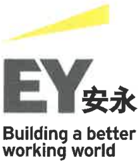
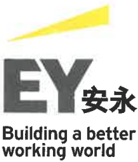
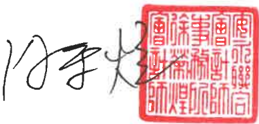
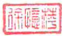
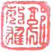
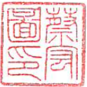
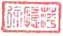
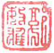
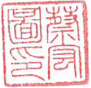
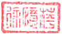
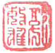
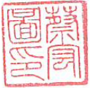
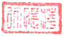
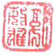
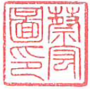
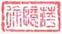
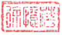
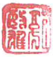
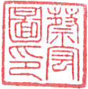
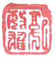
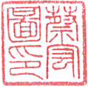
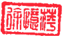
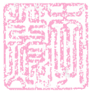
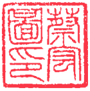
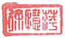
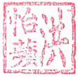
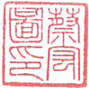
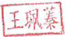
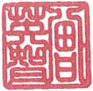
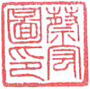
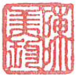
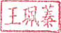
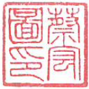
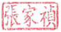
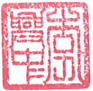
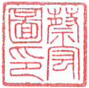
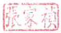
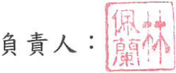
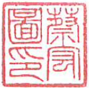
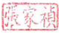
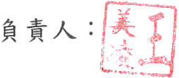
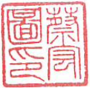
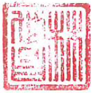
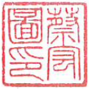
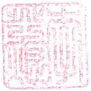
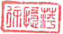
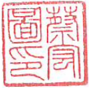
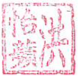
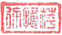
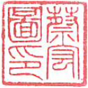
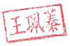
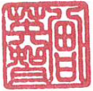
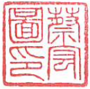
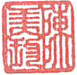
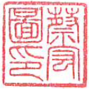
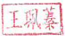
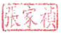
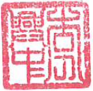
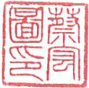
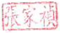
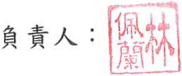
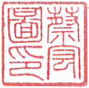
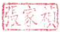
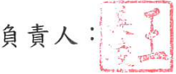
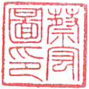
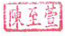
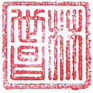
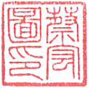
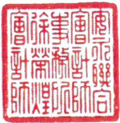
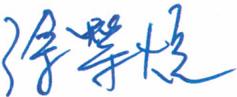
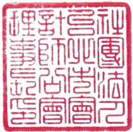
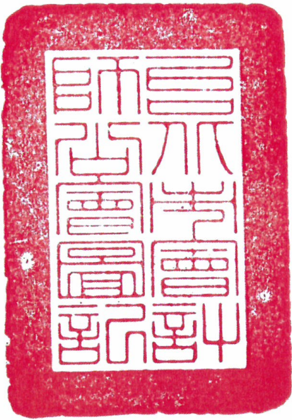
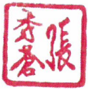
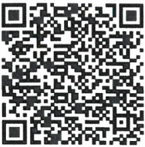

In [18]:
for e, _level in conv_results_list[0].document.iterate_items():
    print(e)

In [ ]:
"""from docling_core.transforms.serializer.base import BaseSerializerProvider, BaseDocSerializer
from docling_core.types.doc.document import DoclingDocument
from docling_core.transforms.chunker.hierarchical_chunker import ChunkingDocSerializer

class PatchedChunkingSerializerProvider(BaseSerializerProvider):
    def get_serializer(self, doc: DoclingDocument) -> BaseDocSerializer:
        patch_dict = {"include_hyperlinks": False}
        patched_params = ChunkingDocSerializer(doc=doc).params.merge_with_patch(patch_dict)
        PatchedChunkingDocSerializer = ChunkingDocSerializer(doc=doc)
        PatchedChunkingDocSerializer.params = patched_params
        return PatchedChunkingDocSerializer"""

hybrid_chunker = HybridChunker(
    tokenizer=tokenizer,
    max_tokens=8000,
    merge_peers=True,  # optional, defaults to True
    serializer_provider = PatchedChunkingSerializerProvider()
)

# text chunks
all_chunks = []
for conv_res in conv_results_list:
    docling_docs = conv_res.document
    chunk_iter = hybrid_chunker.chunk(dl_doc=docling_docs)
    chunks = list(chunk_iter)
    all_chunks += chunks

In [4]:
for i, chunk in enumerate(all_chunks[:]):
    print(f"=== {i} ===")
    txt_tokens = len(tokenizer.tokenize(chunk.text))
    print(f"chunk.text ({txt_tokens} tokens):\n{repr(chunk.text)}")

    ser_txt = hybrid_chunker.serialize(chunk=chunk)
    ser_tokens = len(tokenizer.tokenize(ser_txt))
    print(f"chunker.serialize(chunk) ({ser_tokens} tokens):\n{repr(ser_txt)}")
    #print(f"chunker.serialize(chunk) ({ser_tokens} tokens):\n{ser_txt}")

    print(chunk.meta)

    print()

=== 0 ===
chunk.text (897 tokens):
'民國--二年度及民國---年度\n法人地址：台北市大安區仁愛路四段 280 號0 號\n法人電話：(02)2708-2121\n目 錄\n\n-、封面, 項  目 = . -、封面, 頁  次 = 1. 二、目錄, 項  目 = . 二、目錄, 頁  次 = 2. , 項  目 = 三、會計師查核報告. , 頁  次 = 3-4. , 項  目 = 四、資產負債表. , 頁  次 = 5. , 項  目 = 五、收支餘絀表. , 頁  次 = 6. 六、淨值變動表, 項  目 = . 六、淨值變動表, 頁  次 = 7. 七、現金流量表, 項  目 = . 七、現金流量表, 頁  次 = 8. , 項  目 = 八、財務報表附註. , 頁  次 = . (-), 項  目 = 組織沿革及業務範圍說明. (-), 頁  次 = 9~18. (二), 項  目 = 通過財務報告之日期及程序. (二), 頁  次 = 18. (三), 項  目 = 重要會計政策之彙總說明. (三), 頁  次 = 18~25. (四), 項  目 = 會計變動之理由及其影響. (四), 頁  次 = 26. (五), 項  目 = 重要會計項目之說明. (五), 頁  次 = 26~30. (六), 項  目 = 關係人交易. (六), 頁  次 = 31~33. (七), 項  目 = 質押之資產. (七), 頁  次 = 34. (八), 項  目 = 重大承諾及或有事項. (八), 頁  次 = 34. (九(九), 項  目 = 重大之期後事項. (九(九), 頁  次 = 34. (十), 項  目 = 其他揭露事項. (十), 頁  次 = 34~35. (十-), 項  目 = 教育研究發展及醫療社會服務費用金額表. (十-), 頁  次 = 35. (十二), 項  目 = 與關係人進、銷貨及業務往來表. (十二), 頁  次 = 36. (十三), 項  目 = 進貨交易前十大對象資訊. (十三), 頁  次 = 37~38. (十四), 項  目 = 非健保收入前十大服務項目資訊. (十四), 頁  次 = 39. (十五), 項  目 = 其他支出前十大對象資訊. (十五), 頁  次 = 40

/var/folders/v7/_g3b28s51m532s03dhwffy9c0000gn/T/ipykernel_91177/2500604497.py:6: DeprecationWarning: Use contextualize() instead.
  ser_txt = hybrid_chunker.serialize(chunk=chunk)


chunker.serialize(chunk) (176 tokens):
'8.其他流動資產明細表\n民國--二年十二月三十-日\n單位：新台幣元\n暫付款, 目 = 暫付款. 暫付款, 金\u3000\u3000\u3000\u3000額 = $85,555,442. 暫付款, 備\u3000\u3000\u3000註 = . 其他金融資產(為(為質押定存), 目 = 其他金融資產(為(為質押定存). 其他金融資產(為(為質押定存), 金\u3000\u3000\u3000\u3000額 = 58,273,112. 其他金融資產(為(為質押定存), 備\u3000\u3000\u3000註 = . 合  計, 目 = 合  計. 合  計, 金\u3000\u3000\u3000\u3000額 = $143,828,554. 合  計, 備\u3000\u3000\u3000註 = '
schema_name='docling_core.transforms.chunker.DocMeta' version='1.0.0' doc_items=[DocItem(self_ref='#/texts/705', parent=RefItem(cref='#/body'), children=[], content_layer=<ContentLayer.BODY: 'body'>, label=<DocItemLabel.TEXT: 'text'>, prov=[ProvenanceItem(page_no=69, bbox=BoundingBox(l=216.06143188476562, t=732.300048828125, r=370.61383056640625, b=721.9111328125, coord_origin=<CoordOrigin.BOTTOMLEFT: 'BOTTOMLEFT'>), charspan=(0, 13))]), DocItem(self_ref='#/texts/706', parent=RefItem(cref='#/groups/46'), children=[], content_layer=<ContentLayer.BODY: 'body'>, label=<DocItemLabel.TEXT: 'text'

In [ ]:
for i, chunk in enumerate(all_chunks):
    ser_txt = hybrid_chunker.contextualize(chunk=chunk)
    if re.search(r"<[^>]+>", ser_txt):
        clean_text, replacement_paths = replace_image_tag(ser_txt)
        chunk_text = clean_text
        chunk_meta = chunk.meta.export_json_dict()
        chunk_meta["replacement_paths"] = replacement_paths
        chunk_pair = (chunk_text, chunk_meta)
        all_chunks[i] = chunk_pair
        

In [ ]:
all_chunks

# Rechunk large chunks with RecursiveTextSplitter

In [5]:
big_chunk = []

for i, chunk in enumerate(all_chunks[:]):
    if type(chunk) == tuple:
        ser_txt = chunk[0]
    else:
        ser_txt = hybrid_chunker.serialize(chunk=chunk)
    ser_tokens = len(tokenizer.tokenize(ser_txt))
    if ser_tokens > 1024:
        print(f"=== {i} ===")
        #print(f"chunker.serialize(chunk) ({ser_tokens} tokens):\n{repr(ser_txt)}")
        print(f"chunker.serialize(chunk) ({ser_tokens} tokens):\n{ser_txt}")
        big_chunk.append(chunk)
        print()
    else:
        pass

=== 7 ===
chunker.serialize(chunk) (4014 tokens):
國泰醫療财图法人 资產負债表 中華民國--二年及---年十二月三十-日
流動資產, 资 產.附注 = . 流動資產, 112年12月31日.金额 = $7,205,474,623. 流動資產, 112年12月31日.% = 47. 流動資產, 111年12月31日.金额 = $6,645,514,191. 流動資產, 111年12月31日.% = 45. 流動資產, 負债及净值.會計科目 = 流動負债. 流動資產, 負债及净值.附注 = . 现金及约當现金, 资 產.附注 = 三、五.1、六. 现金及约當现金, 112年12月31日.金额 = 800,293,361. 现金及约當现金, 112年12月31日.% = 5. 现金及约當现金, 111年12月31日.金额 = 1,401,472,005. 现金及约當现金, 111年12月31日.% = 10. 现金及约當现金, 負债及净值.會計科目 = 應付票據. 现金及约當现金, 負债及净值.附注 = . 備供出售金融资產-流動, 资 產.附注 = 三、五.2、六. 備供出售金融资產-流動, 112年12月31日.金额 = 2,639,844,482. 備供出售金融资產-流動, 112年12月31日.% = 17. 備供出售金融资產-流動, 111年12月31日.金额 = 1,850,254,487. 備供出售金融资產-流動, 111年12月31日.% = 12. 備供出售金融资產-流動, 負债及净值.會計科目 = 應付帐款. 備供出售金融资產-流動, 負债及净值.附注 = . 應收票據（减除備抵呆帐後凈额）, 资 產.附注 = 三. 應收票據（减除備抵呆帐後凈额）, 112年12月31日.金额 = 19,450,034. 應收票據（减除備抵呆帐後凈额）, 112年12月31日.% = . 應收票據（减除備抵呆帐後凈额）, 111年12月31日.金额 = 6,000. 應收票據（减除備抵呆帐後凈额）, 111年12月31日.% = . 應收票據（减除備抵呆帐後凈额）, 負债及净值.會計科目 = 其他應付款. 應收票據（减除備抵呆帐後凈额）, 負债及净值.附注 = 三、六. 應收帐款（减除借抵呆帐、借抵支付, 资 產.附注

/var/folders/v7/_g3b28s51m532s03dhwffy9c0000gn/T/ipykernel_91177/499157167.py:7: DeprecationWarning: Use contextualize() instead.
  ser_txt = hybrid_chunker.serialize(chunk=chunk)


In [6]:
splitter = RecursiveTextSplitter(tokenizer=tokenizer, max_tokens=1024, overlap=150, min_length_ratio=1)

rechunked_large_chunks = []

for i, chunk in enumerate(big_chunk):
    if type(chunk) == tuple:
        ser_txt = chunk[0]
    else:
        ser_txt = hybrid_chunker.serialize(chunk=chunk)
        
    if splitter.tokenize_len(ser_txt) > splitter.max_tokens:
        sub_chunks = splitter.split_text(ser_txt)
        sub_chunks_meta = {"filename": chunk.meta.origin.filename}
        sub_chunks_pair = [(text, sub_chunks_meta) for text in sub_chunks]
        rechunked_large_chunks.extend(sub_chunks_pair)
    else:
        rechunked_large_chunks.append(ser_txt)

/var/folders/v7/_g3b28s51m532s03dhwffy9c0000gn/T/ipykernel_91177/2118950735.py:9: DeprecationWarning: Use contextualize() instead.
  ser_txt = hybrid_chunker.serialize(chunk=chunk)


In [7]:
for i, chunk in enumerate(rechunked_large_chunks[:]):
    
    ser_txt = chunk[0]
    ser_tokens = len(tokenizer.tokenize(ser_txt))

    print(f"=== {i} ===")
    #print(f"chunker.serialize(chunk) ({ser_tokens} tokens):\n{repr(ser_txt)}")
    print(f"chunker.serialize(chunk) ({ser_tokens} tokens):\n{ser_txt}")
    print(chunk[1])

    print()

=== 0 ===
chunker.serialize(chunk) (1013 tokens):
國泰醫療财图法人 资產負债表 中華民國--二年及---年十二月三十-日 流動資產, 资 產.附注 =. 流動資產, 112年12月31日.金额 = $7,205,474,623. 流動資產, 112年12月31日.% = 47. 流動資產, 111年12月31日.金额 = $6,645,514,191. 流動資產, 111年12月31日.% = 45. 流動資產, 負债及净值.會計科目 = 流動負债. 流動資產, 負债及净值.附注 =. 现金及约當现金, 资 產.附注 = 三、五.1、六. 现金及约當现金, 112年12月31日.金额 = 800,293,361. 现金及约當现金, 112年12月31日.% = 5. 现金及约當现金, 111年12月31日.金额 = 1,401,472,005. 现金及约當现金, 111年12月31日.% = 10. 现金及约當现金, 負债及净值.會計科目 = 應付票據. 现金及约當现金, 負债及净值.附注 =. 備供出售金融资產-流動, 资 產.附注 = 三、五.2、六. 備供出售金融资產-流動, 112年12月31日.金额 = 2,639,844,482. 備供出售金融资產-流動, 112年12月31日.% = 17. 備供出售金融资產-流動, 111年12月31日.金额 = 1,850,254,487. 備供出售金融资產-流動, 111年12月31日.% = 12. 備供出售金融资產-流動, 負债及净值.會計科目 = 應付帐款. 備供出售金融资產-流動, 負债及净值.附注 =. 應收票據(减除備抵呆帐後凈额), 资 產.附注 = 三. 應收票據(减除備抵呆帐後凈额), 112年12月31日.金额 = 19,450,034. 應收票據(减除備抵呆帐後凈额), 112年12月31日.% =. 應收票據(减除備抵呆帐後凈额), 111年12月31日.金额 = 6,000. 應收票據(减除備抵呆帐後凈额), 111年12月31日.% =. 應收票據(减除備抵呆帐後凈额), 負债及净值.會計科目 = 其他應付款. 應收票據(减除備抵呆帐後凈额), 負债及净值.附注 = 三、六. 應收帐款(减除借抵呆帐、借抵支付, 资 產.附注 =. 應收

# Or table extraction result

In [8]:
# table chunks
all_tables = extract_tables(conv_results_list)

In [9]:
table_formatter = DataFrameFormatter(tokenizer=tokenizer, show_index=False, max_tokens=1024)

table_chunks = []
for table in all_tables:
    chunks = table_formatter.chunk_rows(table[0])
    chunks_pair = [(text, table[1]) for text in chunks]
    table_chunks.extend(chunks_pair)

In [10]:
for i, chunk in enumerate(table_chunks[:]):
    
    ser_txt = chunk[0]
    ser_tokens = len(tokenizer.tokenize(ser_txt))

    print(f"=== {i} ===")
    #print(f"chunker.serialize(chunk) ({ser_tokens} tokens):\n{repr(ser_txt)}")
    print(f"chunker.serialize(chunk) ({ser_tokens} tokens):\n{ser_txt}")
    print(chunk[1])
    print()

=== 0 ===
chunker.serialize(chunk) (693 tokens):
 = -、封面, 頁  次 = 1
 = 二、目錄, 頁  次 = 2
項  目 = 三、會計師查核報告, 頁  次 = 3-4
項  目 = 四、資產負債表, 頁  次 = 5
項  目 = 五、收支餘絀表, 頁  次 = 6
 = 六、淨值變動表, 頁  次 = 7
 = 七、現金流量表, 頁  次 = 8
項  目 = 八、財務報表附註
 = (-), 項  目 = 組織沿革及業務範圍說明, 頁  次 = 9~18
 = (二), 項  目 = 通過財務報告之日期及程序, 頁  次 = 18
 = (三), 項  目 = 重要會計政策之彙總說明, 頁  次 = 18~25
 = (四), 項  目 = 會計變動之理由及其影響, 頁  次 = 26
 = (五), 項  目 = 重要會計項目之說明, 頁  次 = 26~30
 = (六), 項  目 = 關係人交易, 頁  次 = 31~33
 = (七), 項  目 = 質押之資產, 頁  次 = 34
 = (八), 項  目 = 重大承諾及或有事項, 頁  次 = 34
 = (九(九), 項  目 = 重大之期後事項, 頁  次 = 34
 = (十), 項  目 = 其他揭露事項, 頁  次 = 34~35
 = (十-), 項  目 = 教育研究發展及醫療社會服務費用金額表, 頁  次 = 35
 = (十二), 項  目 = 與關係人進、銷貨及業務往來表, 頁  次 = 36
 = (十三), 項  目 = 進貨交易前十大對象資訊, 頁  次 = 37~38
 = (十四), 項  目 = 非健保收入前十大服務項目資訊, 頁  次 = 39
 = (十五), 項  目 = 其他支出前十大對象資訊, 頁  次 = 40
項  目 = (十六) 醫療財團法人之簡明資產負債表, 頁  次 = 41
項  目 = (十七) 醫療財團法人之簡明收支餘絀表, 頁  次 = 41
項  目 = (十八) 醫療財團法人最近兩年度設立或附屬機構簡明資產負債表, 頁  次 = 42~49
項  目 = (十九) 醫療財團法人最近兩年度設立或附屬機構之簡明收支餘絀表, 頁  次 = 50~57
項  目 = (二十) 重要

# Merge all chunks

In [11]:
all_chunks.extend(rechunked_large_chunks)
all_chunks.extend(table_chunks)
#all_chunks.extend(figure_summary_chunks)
all_chunks

[DocChunk(text='民國--二年度及民國---年度\n法人地址：台北市大安區仁愛路四段 280 號0 號\n法人電話：(02)2708-2121\n目 錄\n\n-、封面, 項  目 = . -、封面, 頁  次 = 1. 二、目錄, 項  目 = . 二、目錄, 頁  次 = 2. , 項  目 = 三、會計師查核報告. , 頁  次 = 3-4. , 項  目 = 四、資產負債表. , 頁  次 = 5. , 項  目 = 五、收支餘絀表. , 頁  次 = 6. 六、淨值變動表, 項  目 = . 六、淨值變動表, 頁  次 = 7. 七、現金流量表, 項  目 = . 七、現金流量表, 頁  次 = 8. , 項  目 = 八、財務報表附註. , 頁  次 = . (-), 項  目 = 組織沿革及業務範圍說明. (-), 頁  次 = 9~18. (二), 項  目 = 通過財務報告之日期及程序. (二), 頁  次 = 18. (三), 項  目 = 重要會計政策之彙總說明. (三), 頁  次 = 18~25. (四), 項  目 = 會計變動之理由及其影響. (四), 頁  次 = 26. (五), 項  目 = 重要會計項目之說明. (五), 頁  次 = 26~30. (六), 項  目 = 關係人交易. (六), 頁  次 = 31~33. (七), 項  目 = 質押之資產. (七), 頁  次 = 34. (八), 項  目 = 重大承諾及或有事項. (八), 頁  次 = 34. (九(九), 項  目 = 重大之期後事項. (九(九), 頁  次 = 34. (十), 項  目 = 其他揭露事項. (十), 頁  次 = 34~35. (十-), 項  目 = 教育研究發展及醫療社會服務費用金額表. (十-), 頁  次 = 35. (十二), 項  目 = 與關係人進、銷貨及業務往來表. (十二), 頁  次 = 36. (十三), 項  目 = 進貨交易前十大對象資訊. (十三), 頁  次 = 37~38. (十四), 項  目 = 非健保收入前十大服務項目資訊. (十四), 頁  次 = 39. (十五), 項  目 = 其他支出前十大對象資訊. (十五), 頁  次 = 40. , 項  目 = (十六) 醫療財團

In [12]:
node_text, node_metadatas = [], []
for chunk in all_chunks:
    if type(chunk) == tuple:
        node_text.append(chunk[0])
        meta_dict = chunk[1]
        #node_metadatas.append(json.dumps(meta_dict, indent=4, ensure_ascii=False))
        node_metadatas.append(meta_dict)
    else:
        node_text.append(hybrid_chunker.serialize(chunk=chunk))
        node_metadatas.append(chunk.meta.export_json_dict())

/var/folders/v7/_g3b28s51m532s03dhwffy9c0000gn/T/ipykernel_91177/627654346.py:9: DeprecationWarning: Use contextualize() instead.
  node_text.append(hybrid_chunker.serialize(chunk=chunk))


In [13]:
embedded_text = []
for i in node_text:
    embedded_text.append(get_embeddings(i))

# Qdrant


In [19]:
from qdrant_client import QdrantClient, models

qdrant_client = QdrantClient(host="localhost", port=6333)

scroll_result = qdrant_client.scroll(
    collection_name="qdrant_final_old_docling",
    limit=1000,
    scroll_filter=models.Filter(
        should=[
            models.FieldCondition(
                key="metadata.filename",
                match=models.MatchValue(value="國泰金控員工國外出差要點.pdf")
            ),
            models.FieldCondition(
                key="metadata.origin.filename",
                match=models.MatchValue(value="國泰金控員工國外出差要點.pdf")
            )
        ]
    )
)
scroll_result

([Record(id='02e3116a-1584-4c8c-b79f-d475ef8329f5', payload={'text': '附表-：跨境差旅-宿費及餐雜費標準\n單位：美元日/日元/日\n亞洲地區, 總經理級以上主管   宿費 餐雜費.宿費 = . 亞洲地區, 總經理級以上主管   宿費 餐雜費.餐雜費 = . 亞洲地區, 高階主管.宿費 = . 亞洲地區, 高階主管.餐雜費 = . 亞洲地區, 協理級(含)   以下人員   宿費 餐雜費.宿費 = . 亞洲地區, 協理級(含)   以下人員   宿費 餐雜費.餐雜費 = . 中國大陸, 總經理級以上主管   宿費 餐雜費.宿費 = 檢據實支. 中國大陸, 總經理級以上主管   宿費 餐雜費.餐雜費 = 110或檢據實支. 中國大陸, 高階主管.宿費 = 270. 中國大陸, 高階主管.餐雜費 = 110. 中國大陸, 協理級(含)   以下人員   宿費 餐雜費.宿費 = 215. 中國大陸, 協理級(含)   以下人員   宿費 餐雜費.餐雜費 = 95. 日本(Japan), 總經理級以上主管   宿費 餐雜費.宿費 = 檢據實支. 日本(Japan), 總經理級以上主管   宿費 餐雜費.餐雜費 = 140或檢據實支. 日本(Japan), 高階主管.宿費 = 345. 日本(Japan), 高階主管.餐雜費 = 140. 日本(Japan), 協理級(含)   以下人員   宿費 餐雜費.宿費 = 275. 日本(Japan), 協理級(含)   以下人員   宿費 餐雜費.餐雜費 = 105. 南韓(Korea), 總經理級以上主管   宿費 餐雜費.宿費 = 檢據實支. 南韓(Korea), 總經理級以上主管   宿費 餐雜費.餐雜費 = 130或檢據實支. 南韓(Korea), 高階主管.宿費 = 315. 南韓(Korea), 高階主管.餐雜費 = 130. 南韓(Korea), 協理級(含)   以下人員   宿費 餐雜費.宿費 = 255. 南韓(Korea), 協理級(含)   以下人員   宿費 餐雜費.餐雜費 = 110. 菲律賓(Philippines), 總經理級以上主管   宿費 餐雜費.宿費 = 檢據實支. 菲律賓(Philippines), 總經理級以上主管  

delete_result = qdrant_client.delete(
    collection_name="qdrant_final",
    points_selector=models.FilterSelector(
        filter=models.Filter(
            should=[
                models.FieldCondition(
                    key="metadata.filename",
                    match=models.MatchValue(value="112年國泰醫療財團法人財務報告.pdf")
                ),
                models.FieldCondition(
                    key="metadata.origin.filename",
                    match=models.MatchValue(value="112年國泰醫療財團法人財務報告.pdf")
                )
            ]
        )
    ),
)
delete_result

In [14]:
data = DataObject(node_text, node_metadatas)
data.text[0]

'財務報表暨會計師查核報告\n民國--二年度及民國---年度\n法人地址：台北市大安區仁愛路四段 280 號0 號\n法人電話：(02)2708-2121\n目 錄\n\n-、封面, 項  目 = . -、封面, 頁  次 = 1. 二、目錄, 項  目 = . 二、目錄, 頁  次 = 2. , 項  目 = 三、會計師查核報告. , 頁  次 = 3-4. , 項  目 = 四、資產負債表. , 頁  次 = 5. , 項  目 = 五、收支餘絀表. , 頁  次 = 6. 六、淨值變動表, 項  目 = . 六、淨值變動表, 頁  次 = 7. 七、現金流量表, 項  目 = . 七、現金流量表, 頁  次 = 8. , 項  目 = 八、財務報表附註. , 頁  次 = . (-), 項  目 = 組織沿革及業務範圍說明. (-), 頁  次 = 9~18. (二), 項  目 = 通過財務報告之日期及程序. (二), 頁  次 = 18. (三), 項  目 = 重要會計政策之彙總說明. (三), 頁  次 = 18~25. (四), 項  目 = 會計變動之理由及其影響. (四), 頁  次 = 26. (五), 項  目 = 重要會計項目之說明. (五), 頁  次 = 26~30. (六), 項  目 = 關係人交易. (六), 頁  次 = 31~33. (七), 項  目 = 質押之資產. (七), 頁  次 = 34. (八), 項  目 = 重大承諾及或有事項. (八), 頁  次 = 34. (九(九), 項  目 = 重大之期後事項. (九(九), 頁  次 = 34. (十), 項  目 = 其他揭露事項. (十), 頁  次 = 34~35. (十-), 項  目 = 教育研究發展及醫療社會服務費用金額表. (十-), 頁  次 = 35. (十二), 項  目 = 與關係人進、銷貨及業務往來表. (十二), 頁  次 = 36. (十三), 項  目 = 進貨交易前十大對象資訊. (十三), 頁  次 = 37~38. (十四), 項  目 = 非健保收入前十大服務項目資訊. (十四), 頁  次 = 39. (十五), 項  目 = 其他支出前十大對象資訊. (十五), 頁  次 = 40. , 項  目 = (十六) 醫療財團法

In [15]:
# create a qdrant vectorDB object
vector_db = qdrant_DBConnector("qdrant_final", recreate=False)

In [16]:
# add data to db
vector_db.upsert_vector(embedded_text, data)

upsert finish


# Try chatting!

In [ ]:
"""stream = chat(
    model='deepseek-r1:7b',
    messages=[{'role': 'user', 'content': '妳好'}],
    stream=True,
)

for chunk in stream:
  print(chunk['message']['content'], end='', flush=True)"""

In [ ]:
query = "去中國大陸出差可以申請多少費用？"

print("search for:", query)
bm25_retrieve_result = bm25_retrieval(vector_db, query, top_k=3)
show_json(bm25_retrieve_result)

In [ ]:
embedded_query = get_embeddings(query)
vector_result_json = vector_db.vector_search_json(embedded_query, 3)
print("search for:", query)

show_json(vector_result_json)

In [ ]:
hybrid_result = rrf([vector_result_json, bm25_retrieve_result])

print(json.dumps(hybrid_result, indent=4, ensure_ascii=False))

In [ ]:
#query = "去南非共和國出差可以申請多少費用？"
query = "重要會計項目中，現金及約當現金的銀行存款是多少？"

#print(format_rag_output(reranker(query, hybrid_retriever(query, 20), 0.45)))
print(format_rag_output(reranker(query, hybrid_retriever(vector_db, query, top_k=35), threshold=0.45)))

print()
#for chunk in reranker(query, hybrid_retriever(query, 20)):
for chunk in reranker(query, hybrid_retriever(vector_db, query, top_k=35)):
    print(chunk)
    print()

In [ ]:
# Job instruction
instruction = """
你是台灣國泰集團的聊天機器人秘書，專門為用戶提供公司內外文件內容的解析和答疑，
你的任務是根據你獲得的「參考文件」，對「用戶問題」段落的問題進行回答。

請務必根據「參考文件」中的具體資訊作答，並注意以下要求：
1. 若某些文件內容對回答無幫助，可以忽略，不採用。
2. 若文件內容對回答有幫助，不要忽略任何一絲細節。
3. 回答應簡潔、明確，避免冗長，僅提取關鍵資訊。
4. 若參考文件無法提供答案，請直接回答「我無法根據現有資料回答這個問題」，並不要自行補充。

嚴格使用繁體中文，避免英文或簡體中文。
"""

# User input
#input_text = "去中國大陸出差可以申請多少費用？"
#input_text = "去義大利出差可以申請多少費用？"
#input_text = "去智利出差可以申請多少費用？"
#input_text = "科主管國內出差可以申請多少餐雜宿費？"
#input_text = "商品貨幣是什麼？"
#input_text = "系統開發之安全管理，應包含哪些項目？"
#input_text = "國泰優惠APP 後台維護系統，有什麼功能？"
#input_text = "國泰優惠APP 後台維護系統，功能權限申請流程為何？" 
#input_text = "國泰優惠 APP後台維護系統使用者權限表，有什麼欄位？"
#input_text = "金融科技創新業務之立案及概念測試流程為何？"  
#input_text = "設計阿發時有什麼背景色彩限制？" # Fail? on picture detail explaination, but did catch the words on pics
#input_text = "根據111年度4-6月份捐款及捐贈物資徵信名冊，誰捐了鵝肉湯？" # doc14 fail on parsing compact table index, but seems like it does not interfere with llm answer
#input_text = "根據111年度4-6月份捐款及捐贈物資徵信名冊，梅力化學工業有限公司做了什麼？" # same as above
#input_text = "重要會計項目中，現金及約當現金的銀行存款，111年與112年分別是多少？" # loose structured table, success
input_text = "幫我統整一下不動產、廠房及設備中，成本，折舊以及淨帳面金額數字" # loose structured table, poor recognize result, but success seemingly
#input_text = "請給我應收帳款(淨額)之帳齡分析的內容"
#input_text = "請給我112年，藥品進貨交易對象的名稱，金額及比率"
#input_text = "113年工作計畫有什麼社區服務相關的內容嗎？"
#input_text = "幫我總結一下113年度經費預算與上年度的比較差異"

# RAG retrieved documents
reranked_list = reranker(input_text, hybrid_retriever(vector_db, input_text, 20), threshold=0.45)
rag_docs = format_rag_output(reranked_list)

# Prompt template
prompt = f"""
# 任務
{instruction}

# 參考文件
{rag_docs}

# 用戶問題
{input_text}
"""

print("==== Prompt ====")
print(prompt)
print("================")

# llm calling
if len(rag_docs) != 0:
    response = get_completion(prompt, llm)
else:
    response = "YAh, you retrieved NOTHING!"
print(response)

In [ ]:
text = """1. 摘要圖片的主要內容：
這是一個關於國泰金融控股公司後台維護系統的管理作業流程圖，主要描述了申請、審核、承辦作業及驗收各階段的處理步驟。

2. 擷取重要概念、重點事項或關鍵字：
- 申請人
- 所屬單位
- 生活金融科
- 會員個人資料
- 資料管理單位
- 功能權限
- 帳號對應權限代碼
- 驗收

3. 結構化資訊描述：
- **申請階段**
  1. 申請人提出申請需求
  2. 申請人所屬單位主管審核

- **審核階段**
  3. 生活金融科會辦審核
     - 是否涉及會員個人資料
       - 是：會簽資料所屬單位/資料管理單位/其他相關單位
       - 否：金控資訊部分派申辦單

- **承辦作業階段**
  6. 生活金融科帳號權限設定
     - 功能權限申請是否一致
       - 是：設定帳號對應權限代碼
       - 否：新增代碼對應功能權限

- **驗收階段**
  9. 驗收結案
"""
len(tokenizer.tokenize(text))